# 時系列データセットを学習・評価データに分割する。

```
例えば、2020/01 ~ 2020/12のデータが与えられた時に、 2020/01 ~ 2020/12のデータを全て使用して学習し、
学習した結果生成されたモデルを、2020/12のデータで評価することを考える。しかしこれには問題がある。
この問題を直感的に順を追って説明する。

まず、モデルの生成過程は2020/01 ~ 2020/12のデータから特徴量(X)と目的変数(y)を生成、
このXとyからモデルはXとyの対応関係を学ぶ、といったものである。

次に、評価について考える。今回は2020/12のデータを評価のデータセットとしているが、このデータセットは
学習でも用いられている。つまり学習したことでモデルは2020/12のデータにあるXとyの対応関係を既に学んでいる。
評価ではモデルに対して、2020/12のデータから抽出されたXを入力し予測されたy_hatを得るが、2020/12の
データは学習時に既にモデルによって"見られているため"、カンニングしているようなものである。

そのため学習データと評価データを分割する際は、時期を区別して分割しなければならない。
このノートブックでは、時系列データセットを学習・評価データに分割する方法を紹介していく。
```

# Referrence

[参考: Python: 時系列データの交差検証と TimeSeriesSplit の改良について](https://blog.amedama.jp/entry/time-series-cv)

# Environment

## Library

In [66]:
from calendar import month_name

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit

%matplotlib inline

## Functions

In [69]:
def view_train_test_split(
    data_num: int, l_train_idx: list = l_train_idx, l_test_idx: list = l_test_idx
) -> None:
    """The view of train test split.
    
    Args:
        data_num(int): the number of data set.
        l_train_idx(list): the index of train of data set.
        l_test_idx(list): the index of test of data set.
    
    Returns:
        None
    """
    # 2つ目のデータセット
    train_idx = l_train_idx[data_num]
    test_idx = l_test_idx[data_num]
    train = flights.iloc[train_idx, :]
    test = flights.iloc[test_idx, :]
    display("train:", train.head())
    display("test:", test.head())
    sns.lineplot(data=flights, x="year_month", y="passengers", label="all")
    sns.lineplot(data=train, x="year_month", y="passengers", label="train")
    sns.lineplot(data=test, x="year_month", y="passengers", label="test")

# Main

## seabornに付属する航空機の旅客数の時系列データを読み込む。

In [26]:
flights = sns.load_dataset("flights")
flights.head()

,year,month,passengers
0,1949,Jan,112
1,1949,Feb,118
2,1949,Mar,132
3,1949,Apr,129
4,1949,May,121


## 時系列を表すyear_month列を生成する。

In [27]:
# month列を数値による月に変更するための辞書を生成する。
# NOTE: Jan -> 01
month_name_mapping = {name[:3]: f"{i:02}" for i, name in enumerate(month_name)}
month_name_mapping

{'': '00',
 'Jan': '01',
 'Feb': '02',
 'Mar': '03',
 'Apr': '04',
 'May': '05',
 'Jun': '06',
 'Jul': '07',
 'Aug': '08',
 'Sep': '09',
 'Oct': '10',
 'Nov': '11',
 'Dec': '12'}

In [28]:
# month列を数値による列に変更する。
flights["month_int"] = flights["month"].apply(
    lambda str_3_month_name: month_name_mapping[str_3_month_name]
)
flights.head()

,year,month,passengers,month_int
0,1949,Jan,112,01
1,1949,Feb,118,02
2,1949,Mar,132,03
3,1949,Apr,129,04
4,1949,May,121,05


In [29]:
# year_month列を生成する。
flights["year_month"] = flights["year"].astype(str) + flights["month_int"].astype(str)
flights.head()

,year,month,passengers,month_int,year_month
0,1949,Jan,112,01,194901
1,1949,Feb,118,02,194902
2,1949,Mar,132,03,194903
3,1949,Apr,129,04,194904
4,1949,May,121,05,194905


In [36]:
# year_month列を時系列を表す列としてテーブルに認識させる。
flights["year_month"] = pd.to_datetime(flights["year_month"], format="%Y%m")
flights.head()

,year,month,passengers,month_int,year_month
0,1949,Jan,112,01,1949-01-01
1,1949,Feb,118,02,1949-02-01
2,1949,Mar,132,03,1949-03-01
3,1949,Apr,129,04,1949-04-01
4,1949,May,121,05,1949-05-01


## year_month列を使用して、時系列昇順に並び替える。

In [39]:
flights = flights.sort_values(by="year_month", ascending=True)
flights.head()

,year,month,passengers,month_int,year_month
0,1949,Jan,112,01,1949-01-01
1,1949,Feb,118,02,1949-02-01
2,1949,Mar,132,03,1949-03-01
3,1949,Apr,129,04,1949-04-01
4,1949,May,121,05,1949-05-01


## 分割方法を指定するfold変数を生成する。

In [42]:
fold = TimeSeriesSplit(n_splits=5)
fold

TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None)

In [47]:
l_train_idx = []
l_test_idx = []
for _fold in fold.split(flights):
    train_idx, test_idx = _fold
    l_train_idx.append(train_idx)
    l_test_idx.append(test_idx)

'train:'

,year,month,passengers,month_int,year_month
0,1949,Jan,112,01,1949-01-01
1,1949,Feb,118,02,1949-02-01
2,1949,Mar,132,03,1949-03-01
3,1949,Apr,129,04,1949-04-01
4,1949,May,121,05,1949-05-01


'test:'

,year,month,passengers,month_int,year_month
24,1951,Jan,145,01,1951-01-01
25,1951,Feb,150,02,1951-02-01
26,1951,Mar,178,03,1951-03-01
27,1951,Apr,163,04,1951-04-01
28,1951,May,172,05,1951-05-01


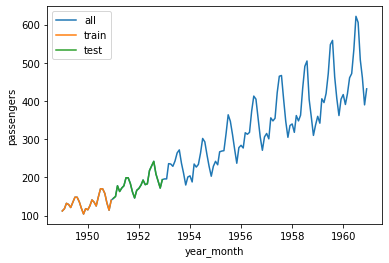

In [70]:
# 1つ目のデータセット
view_train_test_split(0)

```
オレンジ色の区間で学習して、緑色の区間でテストしている。
```

'train:'

,year,month,passengers,month_int,year_month
0,1949,Jan,112,01,1949-01-01
1,1949,Feb,118,02,1949-02-01
2,1949,Mar,132,03,1949-03-01
3,1949,Apr,129,04,1949-04-01
4,1949,May,121,05,1949-05-01


'test:'

,year,month,passengers,month_int,year_month
48,1953,Jan,196,01,1953-01-01
49,1953,Feb,196,02,1953-02-01
50,1953,Mar,236,03,1953-03-01
51,1953,Apr,235,04,1953-04-01
52,1953,May,229,05,1953-05-01


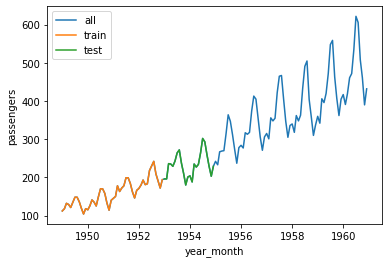

In [71]:
# 2つ目のデータセット
view_train_test_split(1)

```
オレンジ色の区間で学習して、緑色の区間でテストしている。
学習期間が伸びている
```

'train:'

,year,month,passengers,month_int,year_month
0,1949,Jan,112,01,1949-01-01
1,1949,Feb,118,02,1949-02-01
2,1949,Mar,132,03,1949-03-01
3,1949,Apr,129,04,1949-04-01
4,1949,May,121,05,1949-05-01


'test:'

,year,month,passengers,month_int,year_month
72,1955,Jan,242,01,1955-01-01
73,1955,Feb,233,02,1955-02-01
74,1955,Mar,267,03,1955-03-01
75,1955,Apr,269,04,1955-04-01
76,1955,May,270,05,1955-05-01


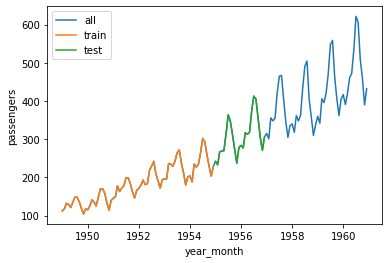

In [72]:
# 3つ目のデータセット
view_train_test_split(2)

```
オレンジ色の区間で学習して、緑色の区間でテストしている。
さらに学習期間が伸びている
```

'train:'

,year,month,passengers,month_int,year_month
0,1949,Jan,112,01,1949-01-01
1,1949,Feb,118,02,1949-02-01
2,1949,Mar,132,03,1949-03-01
3,1949,Apr,129,04,1949-04-01
4,1949,May,121,05,1949-05-01


'test:'

,year,month,passengers,month_int,year_month
96,1957,Jan,315,01,1957-01-01
97,1957,Feb,301,02,1957-02-01
98,1957,Mar,356,03,1957-03-01
99,1957,Apr,348,04,1957-04-01
100,1957,May,355,05,1957-05-01


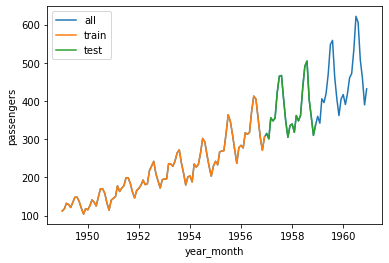

In [73]:
# 4つ目のデータセット
view_train_test_split(3)

```
オレンジ色の区間で学習して、緑色の区間でテストしている。
さらに学習期間が伸びている
```

'train:'

,year,month,passengers,month_int,year_month
0,1949,Jan,112,01,1949-01-01
1,1949,Feb,118,02,1949-02-01
2,1949,Mar,132,03,1949-03-01
3,1949,Apr,129,04,1949-04-01
4,1949,May,121,05,1949-05-01


'test:'

,year,month,passengers,month_int,year_month
120,1959,Jan,360,01,1959-01-01
121,1959,Feb,342,02,1959-02-01
122,1959,Mar,406,03,1959-03-01
123,1959,Apr,396,04,1959-04-01
124,1959,May,420,05,1959-05-01


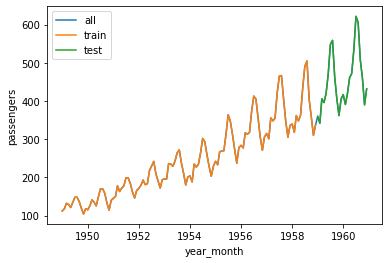

In [74]:
# 5つ目のデータセット
view_train_test_split(4)

```
オレンジ色の区間で学習して、緑色の区間でテストしている。
さらに学習期間が伸びている
```